<h1 style=><center><font color='green'>Face Detection Using Classification</font></center><h1>


<h3><center>Data Analysis and Cleaning: </center><h3>


In [1]:
# importing required libraries
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pywt
import os
import shutil
from PIL import Image
import numpy as np
from numpy import asarray
from numpy import expand_dims
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline


2022-12-03 21:18:54.973548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 21:18:55.341674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 21:18:55.341716: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 21:18:57.224657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
img = cv2.imread('testimg/binny.jpg')  # * opencv function to read image
img.shape


(1944, 2592, 3)

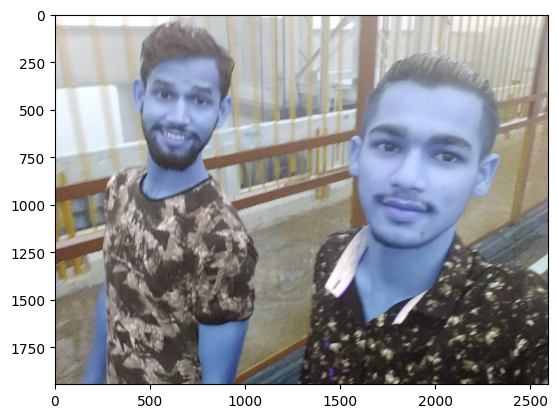

In [3]:
plt.imshow(img)


In [4]:
# * for converting image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape  # * returns a 2-d image array without rgb


(1944, 2592)

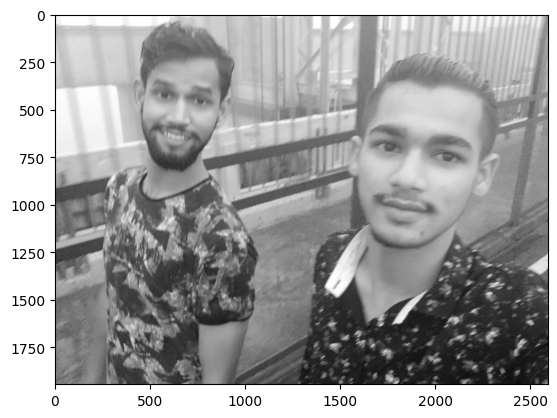

In [5]:
plt.imshow(gray, cmap="gray")


In [6]:
face_cascade = cv2.CascadeClassifier(
    'opencv/haarcascades/haarcascade_frontalface_alt.xml')  # * importing face xml
eye_cascade = cv2.CascadeClassifier(
    'opencv/haarcascades/haarcascade_eye_tree_eyeglasses.xml')  # * importing eye xml

# * detecting faces in 'gray' image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces


array([[ 384,  225,  539,  539],
       [1499,  395,  792,  792]], dtype=int32)

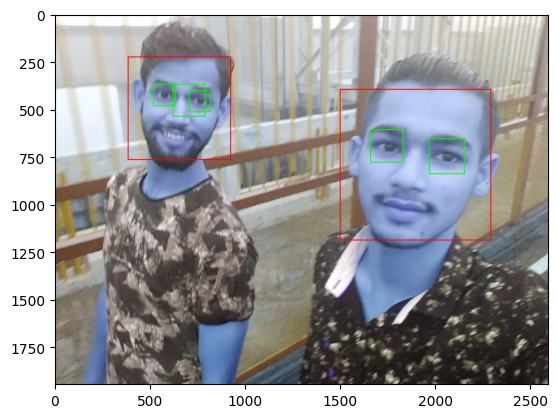

In [7]:
cv2.destroyAllWindows()
for (x, y, w, h) in faces:
    # * highlighting face with red rectangle
    face_img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)
    # * extracting face(region of interest) only from gray image for eye detection
    roi_gray = gray[y:y+h, x:x+w]
    # * extracting face(region of interest) from colored image
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(
        roi_gray)  # * detecting eyes in roi_gray
    for (ex, ey, ew, eh) in eyes:
        # * highlighting eyes in cropped colored image
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 3)
plt.imshow(face_img, cmap='gray')


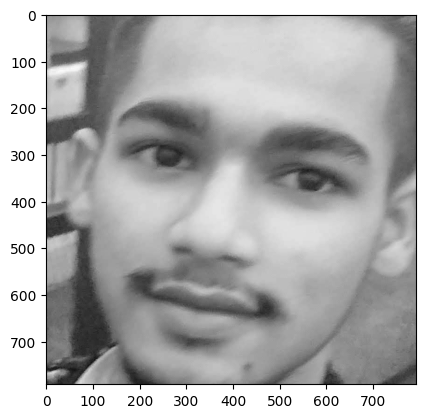

In [8]:
plt.imshow(roi_gray, cmap='gray')


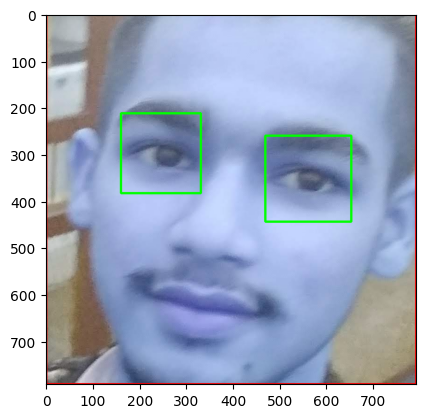

In [9]:
plt.imshow(roi_color, cmap='gray')


In [10]:
# * function for cropping out faces from main image
def get_cropped_img_if_2_eyes(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    roi_color = []  # * array for storing multiple faces

    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) > 0:
            roi_color.append(img[y:y+h, x:x+w])
    roi_required_size = []
    for face in roi_color:
        img = Image.fromarray(face)
        img = img.resize((160, 160))
        face_array = asarray(img)
        roi_required_size.append(face_array)
    return roi_required_size


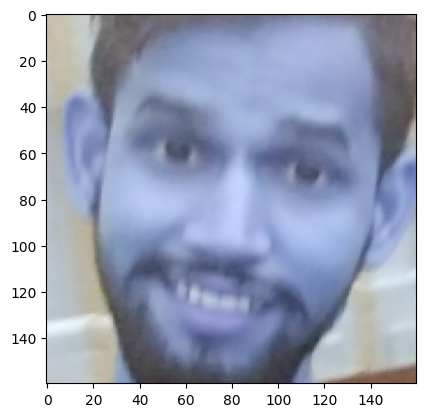

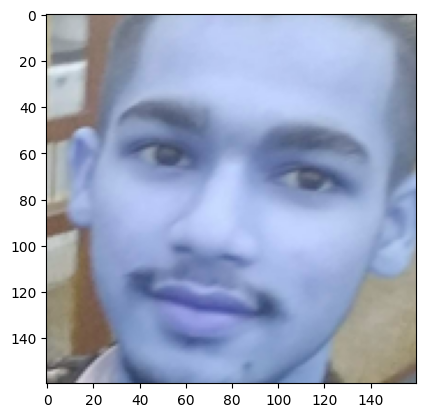

In [11]:
cropped_image = get_cropped_img_if_2_eyes(
    'testimg/binny.jpg')  # * testing above function
for face in cropped_image:
    plt.imshow(face)
    plt.show()


In [12]:
path_to_data = './dataset/'
path_to_cr_data = './dataset/cropped/'


In [13]:
img_dirs = []  # * list for storing directory paths to get names of persons/friends
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs


['./dataset/aayushi',
 './dataset/abhishek',
 './dataset/binod',
 './dataset/sid',
 './dataset/vandana',
 './dataset/cropped']

In [14]:
'''if os.path.exists(path_to_cr_data): #! deleting previous cropped folder and creating a new one. Only run if training model again
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)'''


'if os.path.exists(path_to_cr_data): #! deleting previous cropped folder and creating a new one. Only run if training model again\n    shutil.rmtree(path_to_cr_data)\nos.mkdir(path_to_cr_data)'

In [15]:
'''friend_file_names_dict = {}
for img_dir in img_dirs: #* iterating over each directory inside dataset
    count = 1
    friend_name = img_dir.split('/')[-1] #* extracting person's name from path
    print(friend_name)
    
    for entry in os.scandir(img_dir): #* iterating over each image file inside img_dir
        roi_color = get_cropped_img_if_2_eyes(entry.path) #* cropping out faces and saving them in roi_color
        if len(roi_color) > 0:
            cropped_folder = path_to_cr_data + friend_name #* assigning path for cropped images folder
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            
            for cropped_image in roi_color: #* iterating over each face inside roi_color
                cropped_file_name = friend_name + str(count) + ".png" #* assigning file name of images eg binny1.png, binny2.png
                cropped_file_path = cropped_folder + "/" + cropped_file_name  #* assigning path to each image
                cv2.imwrite(cropped_file_path, cropped_image) #* saving the image in cropped_image to cropped folder
                count += 1 '''


'friend_file_names_dict = {}\nfor img_dir in img_dirs: #* iterating over each directory inside dataset\n    count = 1\n    friend_name = img_dir.split(\'/\')[-1] #* extracting person\'s name from path\n    print(friend_name)\n    \n    for entry in os.scandir(img_dir): #* iterating over each image file inside img_dir\n        roi_color = get_cropped_img_if_2_eyes(entry.path) #* cropping out faces and saving them in roi_color\n        if len(roi_color) > 0:\n            cropped_folder = path_to_cr_data + friend_name #* assigning path for cropped images folder\n            if not os.path.exists(cropped_folder):\n                os.makedirs(cropped_folder)\n                print("Generating cropped images in folder: ",cropped_folder)\n                \n            \n            for cropped_image in roi_color: #* iterating over each face inside roi_color\n                cropped_file_name = friend_name + str(count) + ".png" #* assigning file name of images eg binny1.png, binny2.png\n      

In [16]:
# * creating a dict to store names of friends as keys and file paths as values
friend_file_names_dict = {}
for entry in os.scandir(path_to_cr_data):
    # * extracting friend name from path
    friend_name = entry.path.split('/')[-1]
    # * initializing friend name key inside dict
    friend_file_names_dict[friend_name] = []
    for i in os.scandir(entry.path):
        # * storing image path as value inside dict
        friend_file_names_dict[friend_name].append(i.path)


In [17]:
friend_file_names_dict


{'aayushi': ['./dataset/cropped/aayushi/aayushi4.png',
  './dataset/cropped/aayushi/aayushi7.png',
  './dataset/cropped/aayushi/aayushi14.png',
  './dataset/cropped/aayushi/aayushi18.png',
  './dataset/cropped/aayushi/aayushi19.png',
  './dataset/cropped/aayushi/aayushi20.png',
  './dataset/cropped/aayushi/aayushi24.png',
  './dataset/cropped/aayushi/aayushi25.png',
  './dataset/cropped/aayushi/aayushi26.png',
  './dataset/cropped/aayushi/aayushi27.png',
  './dataset/cropped/aayushi/aayushi28.png',
  './dataset/cropped/aayushi/aayushi29.png',
  './dataset/cropped/aayushi/aayushi30.png',
  './dataset/cropped/aayushi/aayushi31.png',
  './dataset/cropped/aayushi/aayushi33.png',
  './dataset/cropped/aayushi/aayushi34.png',
  './dataset/cropped/aayushi/aayushi35.png',
  './dataset/cropped/aayushi/aayushi36.png',
  './dataset/cropped/aayushi/aayushi37.png',
  './dataset/cropped/aayushi/aayushi38.png',
  './dataset/cropped/aayushi/aayushi39.png',
  './dataset/cropped/aayushi/aayushi41.png',
 

<h3><center>Data Preparation and Stratified Shuffle Split :</center><h3>


In [18]:
class_dict = {}  # * dict for converting and storing friends' names as classes
count = 0
for friend_name in friend_file_names_dict.keys():
    class_dict[friend_name] = count
    count = count + 1
class_dict


{'aayushi': 0, 'abhishek': 1, 'binod': 2, 'sid': 3, 'vandana': 4}

In [19]:
X, y = [], []
for friend_name, training_files in friend_file_names_dict.items():
    for training_image in training_files:  # * iterating over each image path inside friends dict
        img = cv2.imread(training_image)
        X.append(img)  # * storing combined image in X
        # * storing labels/classes of friend names in y
        y.append(class_dict[friend_name])


In [20]:
len(X[0])


160

In [21]:
X[0].shape

(160, 160, 3)

In [22]:
X = asarray(X)


In [23]:
X.shape


(253, 160, 160, 3)

In [24]:
# ! no need to use this conversion if you are using train_test_split
y = np.array(y)
y = y.ravel()  # * making y one-dimensional since Stratified Shuffle was throwing error
y.shape


(253,)

In [25]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 10))])
#pipe.fit(X_train, y_train)
#score = pipe.score(X_test, y_test) * 100
# print('Score:',score,'%')


In [26]:
# * using Stratified Shuffling as no. of images for each friend is different, model fits better with this
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):

    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]


In [27]:
print('trainX', trainX.shape)
print('trainy', trainy.shape)
print('testX', testX.shape)
print('testy', testy.shape)
trainX[0]


trainX (177, 160, 160, 3)
trainy (177,)
testX (76, 160, 160, 3)
testy (76,)


array([[[ 13,  64,  50],
        [ 27,  78,  64],
        [ 23,  74,  60],
        ...,
        [ 14,  32,  29],
        [ 14,  31,  28],
        [ 21,  37,  34]],

       [[  9,  60,  46],
        [ 14,  65,  51],
        [ 20,  71,  57],
        ...,
        [ 34,  49,  47],
        [ 50,  64,  62],
        [ 69,  82,  80]],

       [[ 30,  81,  67],
        [ 12,  63,  49],
        [ 13,  64,  50],
        ...,
        [112, 124, 123],
        [129, 141, 140],
        [138, 149, 147]],

       ...,

       [[ 12,  66,  52],
        [ 10,  64,  51],
        [ 30,  80,  68],
        ...,
        [213, 210, 206],
        [209, 206, 202],
        [201, 198, 194]],

       [[ 11,  64,  51],
        [ 12,  66,  53],
        [ 25,  74,  62],
        ...,
        [201, 198, 194],
        [204, 201, 197],
        [199, 196, 192]],

       [[ 13,  66,  53],
        [ 13,  67,  54],
        [ 21,  71,  59],
        ...,
        [191, 188, 183],
        [197, 194, 190],
        [197, 194, 189]]

<h3><center>Feature/Embedding Extraction using Facenet :</center><h3>

In [28]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]


In [29]:
# load the facenet model
model = load_model('facenet_keras.h5', compile=False)
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)


2022-12-03 21:19:09.496878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sid/Data Science/virtualenv/python3.7/lib/python3.7/site-packages/cv2/../../lib64:
2022-12-03 21:19:09.496925: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 21:19:09.496980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-12-03 21:19:09.520350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Loaded Model
1/1 [==============================] - 0s 47ms/step
(177, 128)
1/1 [==============================] - 0s 48ms/step
(76, 128)


In [30]:
trainX.shape


(177, 160, 160, 3)

In [31]:
newTrainX.shape

(177, 128)

In [32]:
newTrainX[0].shape

(128,)

In [33]:
testX.shape


(76, 160, 160, 3)

In [34]:
newTestX.shape

(76, 128)

<h3><center>Training & Prediction :</center><h3>


In [35]:
# * testing with random HP's
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 10))]) #* testing with random HP's
pipe.fit(newTrainX, trainy)
score = pipe.score(newTestX, testy) * 100
print('Score:', score, '%')


Score: 97.36842105263158 %


In [36]:
# * analyzing precision
print(classification_report(testy, pipe.predict(newTestX)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.88      0.94        17
           2       1.00      1.00      1.00        11
           3       0.92      1.00      0.96        22
           4       1.00      1.00      1.00        16

    accuracy                           0.97        76
   macro avg       0.98      0.98      0.98        76
weighted avg       0.98      0.97      0.97        76



In [37]:
model_params = {  # * dict containing different models and HP's for passing to GridSearchCV

    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear', 'sigmoid']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    },

    'knn': {
        'model': KNeighborsClassifier(),
        'params': {'kneighborsclassifier__n_neighbors': [5, 7, 9, 11, 13, 15]
                   }
    },

    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'decisiontreeclassifier__min_impurity_decrease': [0.2, 0.3, 0.4, 0.5],
            'decisiontreeclassifier__max_depth': [3, 4, 5, 6],
            'decisiontreeclassifier__min_samples_leaf': [3, 4, 5, 6]
        }
    }
}


In [38]:
import pandas as pd
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    # * using GridSearchCV for finding best fiting model
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(newTrainX, trainy)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df  # * printing scores and models with best HP's


,model,best_score,best_params
0,svm,0.994286,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.983175,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.994286,{'logisticregression__C': 1}
3,knn,0.994286,{'kneighborsclassifier__n_neighbors': 5}
4,decision_tree,0.480000,"{'decisiontreeclassifier__max_depth': 3, 'deci..."


In [39]:
best_estimators


{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'knn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())]),
 'decision_tree': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('decisiontreeclassifier',
                  DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.2,
                                         min_samples_leaf=3))])}

In [51]:
print(np.around(best_estimators['logistic_regression'].score(newTestX, testy)*100, 2),'%', sep='')

97.37%


In [52]:
print(np.around(best_estimators['svm'].score(newTestX, testy)*100, 2),'%', sep='')

97.37%


In [53]:
print(np.around(best_estimators['knn'].score(newTestX, testy)*100, 2),'%', sep='')

100.0%


In [43]:
# * chose SVM despite GridSearch showing Logistic Regression better since SVM gives better score on test data.
best_clf1 = best_estimators['svm']


In [44]:
cm = confusion_matrix(testy, best_clf1.predict(newTestX))
cm


array([[10,  0,  0,  0,  0],
       [ 0, 15,  0,  2,  0],
       [ 0,  0, 11,  0,  0],
       [ 0,  0,  0, 22,  0],
       [ 0,  0,  0,  0, 16]])

In [45]:
best_clf2 = best_estimators['logistic_regression']


In [46]:
cm = confusion_matrix(testy, best_clf2.predict(newTestX))
cm


array([[10,  0,  0,  0,  0],
       [ 0, 15,  0,  2,  0],
       [ 0,  0, 11,  0,  0],
       [ 0,  0,  0, 22,  0],
       [ 0,  0,  0,  0, 16]])

In [47]:
best_clf3 = best_estimators['knn']


In [48]:
cm = confusion_matrix(testy, best_clf3.predict(newTestX))
cm


array([[10,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  0],
       [ 0,  0, 11,  0,  0],
       [ 0,  0,  0, 22,  0],
       [ 0,  0,  0,  0, 16]])

{'aayushi': 0, 'abhishek': 1, 'binod': 2, 'sid': 3, 'vandana': 4}


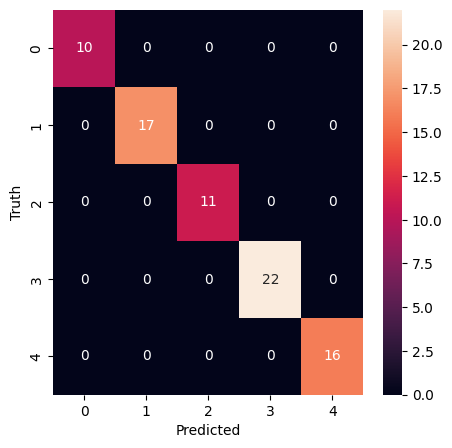

In [49]:
plt.figure(figsize=(5, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(class_dict)


In [51]:
import joblib
# * saving the selected model(svm.SVC)
joblib.dump(best_clf3, 'saved_model_knn.pkl')


['saved_model_knn.pkl']

In [52]:
import json
with open("class_dictionary.json", "w") as f:
    # *saving the class_dict as json for use in backend
    f.write(json.dumps(class_dict))
